In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
# Augmented data save path
path = 'datasets/traffic-signs-augmented-data-equal-n-ang-360'
# mkdir
if not os.path.exists(path):
    os.makedirs(path)

In [3]:
# Image transformation
def affine_transform(img, ang_max, shear_max, trans_max):
    '''
    Apply random affine transformations on an image.
    
    Args:
        img: 1 image array with 3 channels.
        ang_max: integer value to represent max and min values for random
                 angle rotations.
        shear_max: integer value to represent max and min values for random
                   sheering.
        trans_max: integer value to represent max and min values for random
                   translation.
    
    '''
    
    rows = img.shape[0]
    cols = img.shape[1]
    
    # rotation
    rot = np.random.uniform(ang_max) - ang_max / 2
    rot_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rot , 1)

    # shearing
    pts1 = np.float32([[ 10, 10], [20, 10], [10, 20]])
    pt1 = 10 + shear_max * np.random.uniform() - shear_max / 2
    pt2 = 20 + shear_max * np.random.uniform() - shear_max / 2
    pts2 = np.float32([[pt1, 10], [pt2, pt1], [10, pt2]])
    shear_matrix = cv2.getAffineTransform(pts1, pts2)
    
    # translation
    trans_x = trans_max * np.random.uniform() - trans_max / 2
    trans_y = trans_max * np.random.uniform() - trans_max / 2
    trans_matrix = np.float32([[1 , 0, trans_x], [0 , 1, trans_y]])
    
    # affine transformations
    img = cv2.warpAffine(img, rot_matrix,(cols, rows))
    img = cv2.warpAffine(img, trans_matrix,(cols, rows))
    img = cv2.warpAffine(img, shear_matrix,(cols, rows))
    
    return img

In [4]:
# import datasets
training_file = 'datasets/traffic-signs-data/train.p'
validation_file='datasets/traffic-signs-data/valid.p'
testing_file = 'datasets/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# Randomize datasets
np.random.seed(18361)
X_train, y_train = randomize(X_train, y_train)
X_valid, y_valid = randomize(X_valid, y_valid)
X_test, y_test = randomize(X_test, y_test)

random 3 images:


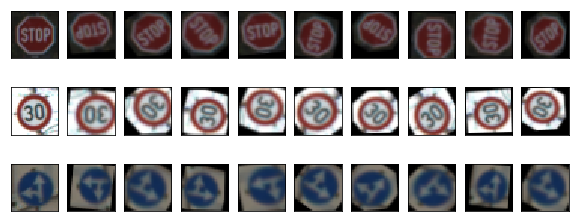

first 3 images:


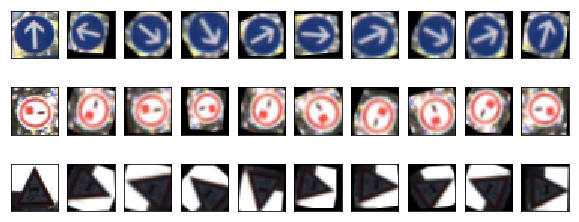

In [5]:
# Test on images

print('random 3 images:')
n_rows = 3
n_cols = 10
fig, axarr = plt.subplots(n_rows, n_cols,
                          figsize=(n_cols, n_rows * (4/3)),
                          subplot_kw={'xticks': [], 'yticks': []})
for i in range(0,3):
    i_img = np.random.randint(X_train.shape[0])
    img = X_train[i_img]
    axarr[i, 0].imshow(img)
    for j in range(1, n_cols):
        trans_img = affine_transform(img, 360, 2, 5)
        axarr[i, j].imshow(trans_img)
plt.show()
plt.close()

print('first 3 images:')

n_rows = 3
n_cols = 10
fig, axarr = plt.subplots(n_rows, n_cols,
                          figsize=(n_cols, n_rows * (4/3)),
                          subplot_kw={'xticks': [], 'yticks': []})

for i in range(0,3):
    img = X_train[i]
    axarr[i, 0].imshow(img)
    for j in range(1, n_cols):
        trans_img = affine_transform(img, 360, 2, 5)
        axarr[i, j].imshow(trans_img)
plt.show()
plt.close()

In [6]:
# Augment all the samples and save

def augment_dataset_equal_numbers(X, Y, ang_max, shear_max, 
                                  trans_max, max_aug=None):
    """This function augments a dataset.
    
    Takes `X` as the features and `Y` as the labels and
    generates extra data to get equal numbers of samples
    for each class. Finally all the classes have a number
    of samples equal to the sample number of the class
    with the highest sample size within the class.
    
    Arguments:
        X: Numpy array as features of all samples.
        Y: Numpy array as labels of all samples. Labels should start with `0`.
        ang_max: An integer to represent the angle range.
        shear_max: An integer to represent the shear range.
        trans_max: An integer to represent the transformation range.
        max_aug: An integer value to be equal to the number of samples
                 for each class in the augmented dataset. If `None`
                 sample number of the class with the max sample size will
                 be used.
    """
    n_classes = Y.max() + 1
    max_n_sample = 0.
    n_class_samples = {}
    for i in range(n_classes):
        n_sample = np.where(Y == i)[0].size
        n_class_samples[i] = n_sample
        if max_n_sample < n_sample:
            max_n_sample = n_sample
    if not max_aug is None:
        max_n_sample = max_aug
    for i in range(0, n_classes):
        n_samples = n_class_samples[i]
        if n_samples != max_n_sample:
            diff = max_n_sample - n_samples
            figs = X[np.where(Y == i)[0]]
            label = i
            X_aug = []
            Y_aug = [label] * diff
            for j in range(diff):
                img = figs[j % n_samples]
                trans_img = affine_transform(img, ang_max, shear_max, trans_max)
                X_aug.append(trans_img)
            X = np.concatenate((X, X_aug), axis=0)
            Y = np.concatenate((Y, Y_aug))    
    # randomize dataset
    X, Y = randomize(X, Y) # close here for testing
    return X, Y

X_train_aug, Y_train_aug = augment_dataset_equal_numbers(X_train, y_train, 360, 2, 5)
X_valid_aug, Y_valid_aug = augment_dataset_equal_numbers(X_valid, y_valid, 360, 2, 5,
                                                         max_aug=2000)


In [7]:
print(X_train_aug.shape)
print(X_train.shape)
print(X_train_aug.shape[0] - X_train.shape[0])

(86430, 32, 32, 3)
(34799, 32, 32, 3)
51631


In [8]:
# save augmented datasets
data_train, data_valid = {}, {}
data_train['features'], data_train['labels'] = X_train_aug, Y_train_aug
data_valid['features'], data_valid['labels'] = X_valid_aug, Y_valid_aug

with open(path + '/train.p', mode='wb') as f:
    pickle.dump(data_train, f)
with open(path + '/valid.p', mode='wb') as f:
    pickle.dump(data_valid, f)

In [9]:
for i in range(Y_train_aug.max() + 1):
    print(str(np.where(Y_train_aug == i)[0].size) + ' for class ' + str(i))

2010 for class 0
2010 for class 1
2010 for class 2
2010 for class 3
2010 for class 4
2010 for class 5
2010 for class 6
2010 for class 7
2010 for class 8
2010 for class 9
2010 for class 10
2010 for class 11
2010 for class 12
2010 for class 13
2010 for class 14
2010 for class 15
2010 for class 16
2010 for class 17
2010 for class 18
2010 for class 19
2010 for class 20
2010 for class 21
2010 for class 22
2010 for class 23
2010 for class 24
2010 for class 25
2010 for class 26
2010 for class 27
2010 for class 28
2010 for class 29
2010 for class 30
2010 for class 31
2010 for class 32
2010 for class 33
2010 for class 34
2010 for class 35
2010 for class 36
2010 for class 37
2010 for class 38
2010 for class 39
2010 for class 40
2010 for class 41
2010 for class 42


In [10]:
for i in range(Y_valid_aug.max() + 1):
    print(str(np.where(Y_valid_aug == i)[0].size) + ' for class ' + str(i))

2000 for class 0
2000 for class 1
2000 for class 2
2000 for class 3
2000 for class 4
2000 for class 5
2000 for class 6
2000 for class 7
2000 for class 8
2000 for class 9
2000 for class 10
2000 for class 11
2000 for class 12
2000 for class 13
2000 for class 14
2000 for class 15
2000 for class 16
2000 for class 17
2000 for class 18
2000 for class 19
2000 for class 20
2000 for class 21
2000 for class 22
2000 for class 23
2000 for class 24
2000 for class 25
2000 for class 26
2000 for class 27
2000 for class 28
2000 for class 29
2000 for class 30
2000 for class 31
2000 for class 32
2000 for class 33
2000 for class 34
2000 for class 35
2000 for class 36
2000 for class 37
2000 for class 38
2000 for class 39
2000 for class 40
2000 for class 41
2000 for class 42


### Testing part (optional):

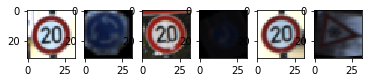

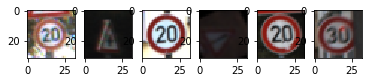

In [11]:
#testing
# if test, please close # randomize dataset
                        #X, Y = randomize(X, Y)
# part.

figs = X_train[np.where(y_train == 0)[0]]

plt.subplot(161)
plt.imshow(figs[0])
plt.subplot(162)
plt.imshow(X_train_aug[34799])
plt.subplot(163)
plt.imshow(figs[1])
plt.subplot(164)
plt.imshow(X_train_aug[34800])
plt.subplot(165)
plt.imshow(figs[2])
plt.subplot(166)
plt.imshow(X_train_aug[34801])
plt.show()
plt.close()

plt.subplot(161)
plt.imshow(figs[3])
plt.subplot(162)
plt.imshow(X_train_aug[34802])
plt.subplot(163)
plt.imshow(figs[4])
plt.subplot(164)
plt.imshow(X_train_aug[34803])
plt.subplot(165)
plt.imshow(figs[5])
plt.subplot(166)
plt.imshow(X_train_aug[34804])
plt.show()
plt.close()